In [470]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [429]:
data = pd.read_csv("train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [430]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

Artist Name и Track Name - единственные нечисленные колонки в таблице, mode, time_signature и Class - целочисленные колонки, остальные - float.

In [431]:
data.nunique()

Artist Name            9149
Track Name            15129
Popularity              100
danceability            909
energy                 1208
key                      11
loudness               9002
mode                      2
speechiness            1194
acousticness           3930
instrumentalness       4253
liveness               1459
valence                1320
tempo                 13562
duration_in min/ms    14121
time_signature            4
Class                    11
dtype: int64

key, mode, time_signature, class - скорее категориальные признаки. Давайте трансформируем колонки

In [432]:
data[['key', 'mode', 'time_signature', 'Class']] = data[['key', 'mode', 'time_signature', 'Class']].astype('category')

In [433]:
data.describe()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms
count,17568.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04
mean,44.512124,0.543433,0.662777,-7.910660,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05
std,17.426928,0.166268,0.235373,4.049151,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05
min,1.000000,0.059600,0.000020,-39.952000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01
25%,33.000000,0.432000,0.509000,-9.538000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05
50%,44.000000,0.545000,0.700000,-7.016000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05
75%,56.000000,0.659000,0.860000,-5.189000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05
max,100.000000,0.989000,1.000000,1.355000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06


array([[<Axes: title={'center': 'Popularity'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'acousticness'}>],
       [<Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'valence'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'duration_in min/ms'}>, <Axes: >]],
      dtype=object)

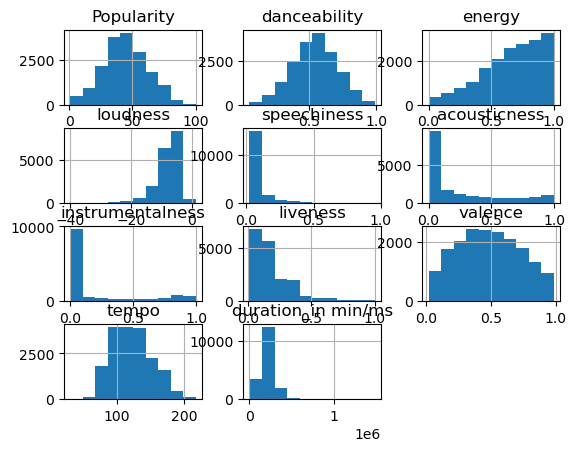

In [434]:
data.hist()

In [435]:
data.isna().sum() # В некоторых колонках достаточно большое количество na, давайте попробуем их выкинуть и посмотреть, какое количество данных останется

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

In [436]:
data.dropna().info() # 6 тысяч строк выкинулось - достаточно много. Давайте все таки заменим нан на среднее значение фичи по данному классу

<class 'pandas.core.frame.DataFrame'>
Index: 11813 entries, 1 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Artist Name         11813 non-null  object  
 1   Track Name          11813 non-null  object  
 2   Popularity          11813 non-null  float64 
 3   danceability        11813 non-null  float64 
 4   energy              11813 non-null  float64 
 5   key                 11813 non-null  category
 6   loudness            11813 non-null  float64 
 7   mode                11813 non-null  category
 8   speechiness         11813 non-null  float64 
 9   acousticness        11813 non-null  float64 
 10  instrumentalness    11813 non-null  float64 
 11  liveness            11813 non-null  float64 
 12  valence             11813 non-null  float64 
 13  tempo               11813 non-null  float64 
 14  duration_in min/ms  11813 non-null  float64 
 15  time_signature      11813 non-null  categ

In [437]:
data.Popularity = data.Popularity.fillna(data.groupby('Class')['Popularity'].transform(lambda x: x.mean()))
data.instrumentalness = data.instrumentalness.fillna(data.groupby('Class')['instrumentalness'].transform(lambda x: x.mean()))
data.key = data.groupby('Class')['key'].transform(lambda x: x.mode().iloc[0])

/tmp/ipykernel_1758/376301317.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.Popularity = data.Popularity.fillna(data.groupby('Class')['Popularity'].transform(lambda x: x.mean()))
/tmp/ipykernel_1758/376301317.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.instrumentalness = data.instrumentalness.fillna(data.groupby('Class')['instrumentalness'].transform(lambda x: x.mean()))
/tmp/ipykernel_1758/376301317.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

Давайте посмотрим теперь на баланс классов

In [454]:
data.groupby('Class').size()

/tmp/ipykernel_1758/2363223037.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('Class').size()


Class
0      625
1     1373
2     1272
3      402
4      387
5     1447
6     2587
7      576
8     1854
9     2524
10    4949
dtype: int64

Классы распределены неравномерно, можно использовать resampling или/и weighted f1 score для компенсации

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Имена треков и артистов можно выбросить, в первом случае у нас просто шум, во втором случае мы будем хуже предсказывать артистов, отсутствующих в нашей тренировочной выборке.

In [ ]:
data = data.drop(columns=['Artist Name', 'Track Name'])

Для подбора гиперпараметров используем GridSearchCV, а для оценки модели - f1 score, так как FN или FP нам одинаково неприятны и нам б хотелось учесть неравномерность распределения классов.

In [472]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Class'),
                                                    data.Class,
                                                    test_size=0.3,
                                                    random_state=42)

decision_tree = DecisionTreeClassifier()
param_grid = { 
    'max_depth' : [3,4,5,6,7,8,9,10,15,20,30,50],
    'criterion' :['gini', 'entropy','log_loss']
}
decision_tree = GridSearchCV(decision_tree, param_grid, cv=10)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print('f1score decision tree', f1_score(y_test, y_pred, average='weighted')) # wighted чтобы учесть дисбаланс

f1score decision tree 0.9017504966008815


0.9 для weighted f1 очень даже неплохо!

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

In [482]:
scaler = StandardScaler()
pca = PCA() 
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
param_grid = {
    "pca__n_components": [5, 8, 10, 12, 14],
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

logistic_regression = GridSearchCV(pipe, param_grid, cv=10)
logistic_regression.fit(X_train, y_train)
y_pred_lr = logistic_regression.predict(X_test)

print('f1score logistic regresion', f1_score(y_test, y_pred_lr, average='weighted'))


f1score logistic regresion 0.47184779967504376


In [483]:
scaler = StandardScaler()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

logistic_regression = GridSearchCV(pipe, param_grid, cv=10)
logistic_regression.fit(X_train, y_train)
y_pred_lr = logistic_regression.predict(X_test)

print('f1score logistic regresion', f1_score(y_test, y_pred_lr, average='weighted'))

f1score logistic regresion 0.47184779967504376


PCA никак не влияет на итоговый результат, интересно почему ...

In [481]:
k_neighbors = KNeighborsClassifier()
param_grid = {
    'kn__n_neighbors': [3, 5, 7, 9, 11, 20, 40],
    'kn__weights': ['uniform', 'distance']
}
pipe = Pipeline(steps=[("scaler", scaler), ("kn", k_neighbors)])
k_neighbors = GridSearchCV(pipe, param_grid, cv=10)
k_neighbors.fit(X_train, y_train)
y_pred_k_neighbors = k_neighbors.predict(X_test)

print('f1score K neighbours', f1_score(y_test, y_pred_k_neighbors, average='weighted'))

f1score K neighbours 0.7151308367585193


Все результаты показывают резльтат хуже, чем у decision tree

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Олдбой 2003 года - просто нужно смотреть. любое краткое описание этого фильма - кострация.

2. Падшие ангелы 1995 - для меня синоним "стиля" в кинематографе + любимая работа Вонга Карвая

3. Крутой учитель Онидзука - не очень люблю сериалы, но этот мультфильм исключение. Что будет, если бывший главарь байкеров без опыта, компетенций и знаний решит стать школьным учителем? А если ему дадут на попечеие самый проблемный класс за всю историю школы, который раз за разом доводил классух до ручки? Получится самая трогательная трагикомедия, которую вы когда либо смотрели.

Топ вышел слишком восточным, но да ладно.